In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from libs.utils import montage

from libs import gif
import IPython.display as ipyd
plt.style.use('ggplot')
%matplotlib inline

In [2]:
from libs.datasets import MNIST

ds = MNIST()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
n_features = ds.X.shape[1]
n_features

784

In [4]:
mean_img = np.mean(ds.X, axis=0)

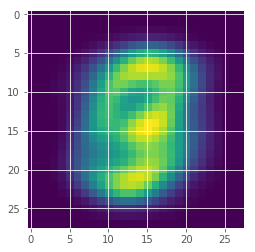

In [8]:
plt.imshow(np.reshape(mean_img, (28,28)))

In [5]:
X = tf.placeholder(tf.float32, shape=(None, n_features))

In [6]:
X_tensor = tf.reshape(X, [-1, 28, 28, 1]) # convert to 4d tensor to prep for convolution

In [7]:
n_filters = [16,16,16]
filter_sizes = [4,4,4]

In [9]:
# build convolutional encoder

current_input = X_tensor

n_input = 1

Ws = [] # keeping all weights for decoding
shapes = [] #keep track of shapes of each layer

# create convolutional layers

for layer_i, n_output in enumerate(n_filters):
    with tf.variable_scope("encoder/layer/{}".format(layer_i)):
        shapes.append(current_input.get_shape().as_list())
        
        W = tf.get_variable(name='W',
                           shape=[
                               filter_sizes[layer_i],
                               filter_sizes[layer_i],
                               n_input,
                               n_output
                           ],
                           initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))
        
        h = tf.nn.conv2d(current_input, W, strides=[1,2,2,1], padding='SAME')
        
        current_input = tf.nn.relu(h)
        
        Ws.append(W) # keep track of weights
        
        n_input = n_output

In [10]:
#build convolutional decoder

#reverse everything
Ws.reverse()
shapes.reverse()
n_filters.reverse()
n_filters = n_filters[1:] + [1] #remove first elt and add 1 for output image from decoder

print(n_filters, shapes)
print(current_input.get_shape())

[16, 16, 1] [[None, 7, 7, 16], [None, 14, 14, 16], [None, 28, 28, 1]]
(?, 4, 4, 16)


In [11]:
for layer_i, shape in enumerate(shapes):
    with tf.variable_scope("decoder/layer/{}".format(layer_i)):
        
        W = Ws[layer_i]
        
        h = tf.nn.conv2d_transpose(current_input, W, (tf.shape(X)[0], shape[1], shape[2], shape[3]),
                                  strides=[1,2,2,1], padding='SAME')
        # third value in cov2d_transpose is the output shape, so cycle through output shapes in reverse to reach original image
        current_input = tf.nn.relu(h)

In [12]:
Y = current_input
Y = tf.reshape(Y, [-1, n_features])

In [13]:
cost = tf.reduce_mean(tf.reduce_mean(tf.squared_difference(X,Y),1))
learning_rate = 0.001

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [14]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [15]:
batch_size = 100
epochs = 5

examples = ds.X[:100]

0 0.0258141
1 0.0246106
2 0.024015
3 0.0243331
4 0.0245844


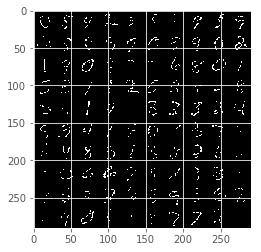

In [17]:
imgs = []
fig,ax = plt.subplots(1,1)

for epoch_i in range(epochs):
    for batch_X, _ in ds.train.next_batch():
        sess.run(optimizer, feed_dict={X:batch_X-mean_img})
    
    recon = sess.run(Y, feed_dict={X: examples-mean_img})
    recon = np.clip((recon + mean_img).reshape((-1, 28,28)), 0,255)
    img_i = montage(recon).astype(np.uint8)
    imgs.append(img_i)
    ax.imshow(img_i, cmap='gray')
    fig.canvas.draw()
    print(epoch_i, sess.run(cost, feed_dict={X:batch_X - mean_img}))

#gif.build_gif(imgs, saveto='convo-ae.gif', cmap='gif')